# Определение возраста покупателей

## Цель проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
 - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

<div class="alert alert-success">
<h2> Комментарий ревьюера v1 <a class="tocSkip"> </h2>

<b>Все супер!👍:</b> Елена, здорово, что не забываешь о введении в проект! Ты ясно и четко формулируешь цель нашего исследования, что дает нам прочную основу для дальнейших этапов. Так держать!
    


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Исследовательский анализ данных

In [2]:
# Путь к данным
data_dir = '/datasets/faces/final_files/'
labels_path = '/datasets/faces/labels.csv'

# Загрузка CSV-файла
labels = pd.read_csv(labels_path)

# Просмотр первых строк
print(labels.head())
print(f"Размер выборки: {labels.shape}")

    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17
Размер выборки: (7591, 2)


<div class="alert alert-success">
<h2> Комментарий ревьюера v1 <a class="tocSkip"> </h2>

<b>Все супер!👍:</b> Датасет подгрузили, можем приступать к исследованию

Построим график распределения возраста в выборке

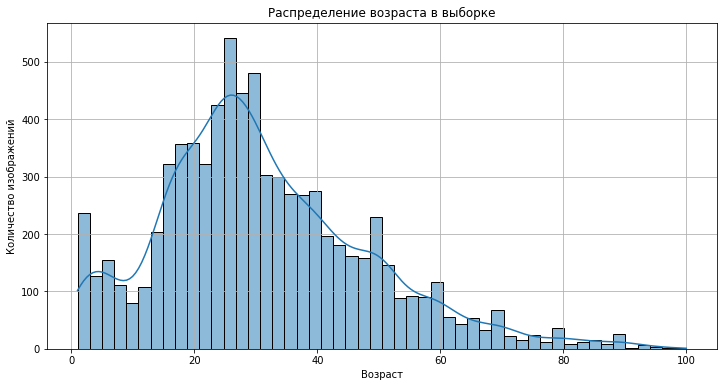

In [3]:
plt.figure(figsize=(12, 6))
sns.histplot(labels['real_age'], bins=50, kde=True)
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.grid(True)
plt.show()

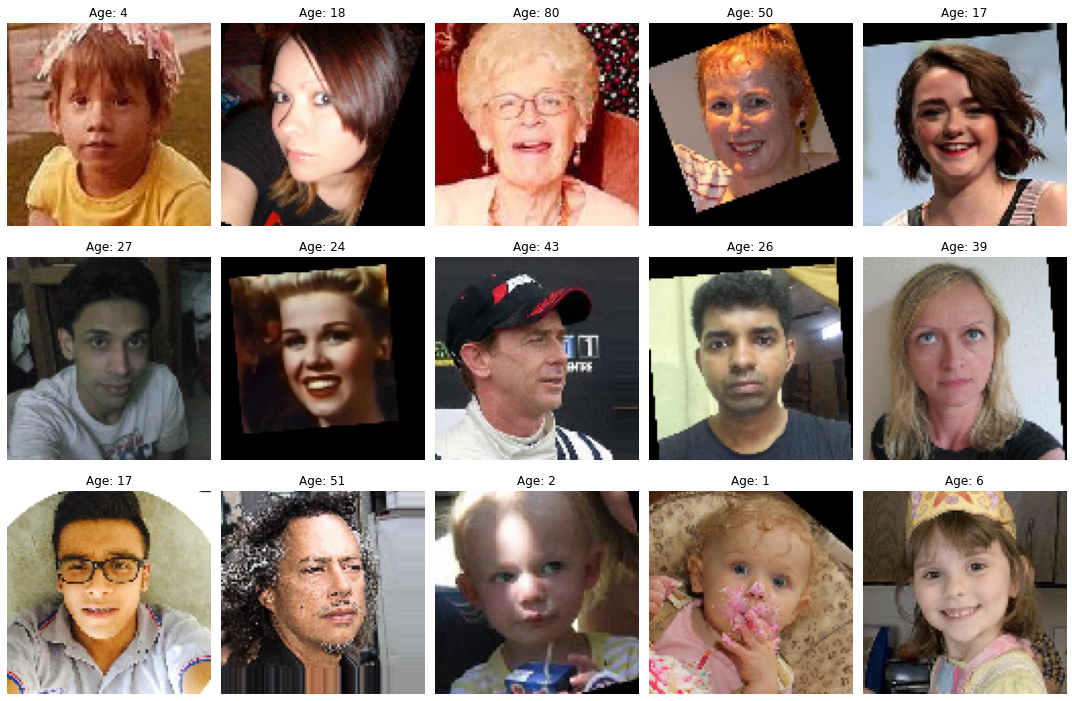

In [4]:
# Показать первые 15 изображений с подписями (возраст)
plt.figure(figsize=(15, 10))

for i in range(15):
    file_name = labels.iloc[i]['file_name']
    age = labels.iloc[i]['real_age']
    img_path = os.path.join(data_dir, file_name)
    
    img = load_img(img_path, target_size=(100, 100))  # уменьшаем размер для визуализации
    
    plt.subplot(3, 5, i + 1)
    plt.imshow(img)
    plt.title(f'Age: {age}')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Промежуточный вывод

1. Размер выборки: около 7,5 тысяч изображений.
2. Распределение возраста **смещено влево**: много изображений людей до 30 лет, меньше — старших возрастов.
3. Изображения разнообразны, присутствуют разные ракурсы, освещение, фон, выражения лиц и т.д.

**Как это повлияет на обучение модели:**

- Неравномерность распределения возрастов может привести к смещённому обучению — модель будет лучше предсказывать молодые возраста.


## Обучение модели

В этот раздел перенесён код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# код скопирован со всеми импортами, как был загружен в тренажер

import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def load_train(path):
    df = pd.read_csv(os.path.join(path, 'labels.csv'))
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.3
    )
    train_gen = datagen.flow_from_dataframe(
        dataframe=df,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=123
    )
    return train_gen

def load_test(path):
    df = pd.read_csv(os.path.join(path, 'labels.csv'))
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )
    test_gen = datagen.flow_from_dataframe(
        dataframe=df,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=123
    )
    return test_gen

def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False
    )
    backbone.trainable = True

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='mse',
        metrics=['mae']
    )
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    callbacks = [
        EarlyStopping(patience=3, restore_best_weights=True),
        ModelCheckpoint('best_model.h5', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)
    ]

    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch or len(train_data),
        validation_steps=validation_steps or len(test_data),
        callbacks=callbacks,
        verbose=2
    )
    return model

if __name__ == '__main__':
    path = '/datasets/faces/'
    train_gen = load_train(path)
    test_gen = load_test(path)

    model = create_model((150, 150, 3))
    model = train_model(
        model,
        train_gen,
        test_gen,
        steps_per_epoch=train_gen.samples // train_gen.batch_size,
        validation_steps=test_gen.samples // test_gen.batch_size
    )

    loss, mae = model.evaluate(test_gen)
    print(f"\nMAE на тестовой выборке: {mae:.2f}")

```

```

# Результат вывода на экран (длинные строки со скачиванием модели удалены):

Found 6073 validated image filenames.
Found 1518 validated image filenames.

Train for 190 steps, validate for 48 steps
Epoch 1/10
190/190 - 109s - loss: 254.2927 - mae: 12.1063 - val_loss: 608.2599 - val_mae: 19.5173
Epoch 2/10
190/190 - 78s - loss: 158.5293 - mae: 9.5539 - val_loss: 426.6711 - val_mae: 15.4746
Epoch 3/10
190/190 - 77s - loss: 133.1571 - mae: 8.8395 - val_loss: 288.0958 - val_mae: 12.8299
Epoch 4/10
190/190 - 76s - loss: 124.3726 - mae: 8.5097 - val_loss: 180.0024 - val_mae: 9.9758
Epoch 5/10
190/190 - 75s - loss: 113.6304 - mae: 8.1869 - val_loss: 111.6380 - val_mae: 7.9142
Epoch 6/10
190/190 - 75s - loss: 104.2374 - mae: 7.8741 - val_loss: 103.5132 - val_mae: 7.5565
Epoch 7/10
190/190 - 75s - loss: 101.6980 - mae: 7.7634 - val_loss: 98.5082 - val_mae: 7.3757
Epoch 8/10
190/190 - 73s - loss: 97.3024 - mae: 7.5232 - val_loss: 108.5649 - val_mae: 7.8758
Epoch 9/10
190/190 - 73s - loss: 89.4763 - mae: 7.2607 - val_loss: 106.4202 - val_mae: 7.7380
Epoch 10/10
190/190 - 75s - loss: 74.8337 - mae: 6.6250 - val_loss: 85.2396 - val_mae: 6.8685
WARNING:tensorflow:sample_weight modes were coerced from
...
to
['...']
48/48 - 8s - loss: 85.2396 - mae: 6.8685


```

## Анализ обученной модели

1.	Обучение и валидация идут успешно - значения метрики mae (средняя абсолютная ошибка) постепенно уменьшаются как на тренировочных, так и на валидационных данных. Это хороший признак — модель учится.
2. Финальное значение mae на валидации примерно 6.87, что соответствует условию задачи.
3. Вывод модели (loss и mae на тесте) совпадает с последней эпохой, значит сохранённые веса и восстановленные при restore_best_weights=True работают корректно.

Вывод - можно сказать, что система предсказывет возраст с погрешностью примерно в 7 лет, это, конечно, не обеспечит стопроцентную гарантию, что алкоголь не попадет в руки несовершеннолетним, но поможет минимизировать процент нарушений, а также поможет давать рекомендации в соответствии с возрастом и, тем самым, повысить лояльность покупателя.